In [1]:
import sys
print(sys.version)
print(sys.path)
sys.path.remove('/home/obin/catkin_ws/devel/lib/python2.7/dist-packages')
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
['', '/home/obin/catkin_ws/devel/lib/python2.7/dist-packages', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/obin/.local/lib/python3.5/site-packages', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/home/obin/.local/lib/python3.5/site-packages/IPython/extensions', '/home/obin/.ipython']


# Data Process

In [2]:
#import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import joblib
#import scipy.misc
import tensorflow as tf
#from skimage.restoration import denoise_tv_chambolle
from tensorboardX import SummaryWriter
import copy

In [3]:
pp_path = '/home/obin/t2b_dataset/meta_data'
rg_path = '/home/obin/t2b_dataset/rgbd_data'
meta_list = np.sort([pp_path+'/'+x for x in os.listdir(pp_path)])
rgbd_list = np.sort([rg_path+'/'+x for x in os.listdir(rg_path)])
num_data = len(meta_list)
print('num of data : ', num_data)

num of data :  342


## depth image preprocess

In [5]:
#np.random.shuffle(data_list)
data_list

NameError: name 'data_list' is not defined

# black patch

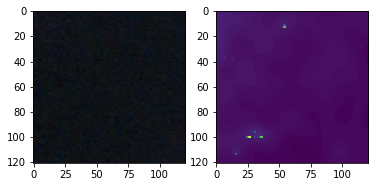

(242, 242, 4)

In [6]:
img = joblib.load('/home/obin/t2b_dataset/rgbd_data/0003/0003.dat.gz')
black_patch = np.uint8(img[10:131,10:131,:]*255)
#black_patch[:,:,0:3] = cv2.cvtColor(black_patch[:,:,0:3],cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(black_patch[:,:,0:3])
plt.subplot(122)
plt.imshow(black_patch[:,:,3])
plt.show()
black_patch = np.hstack([black_patch,black_patch])
black_patch = np.vstack([black_patch,black_patch])
black_patch.shape

In [7]:
img

array([[[0.03137255, 0.05098039, 0.10980392, 0.08006452],
        [0.03137255, 0.05098039, 0.12941176, 0.08027312],
        [0.03921569, 0.05490196, 0.12941176, 0.08066981],
        ...,
        [0.07058824, 0.12156863, 0.14117647, 0.05320223],
        [0.0627451 , 0.11372549, 0.13333333, 0.05340357],
        [0.07058824, 0.11372549, 0.14901961, 0.05350486]],

       [[0.02352941, 0.05490196, 0.09803922, 0.08050989],
        [0.03137255, 0.0627451 , 0.13333333, 0.08076669],
        [0.04313725, 0.05882353, 0.1254902 , 0.08129766],
        ...,
        [0.07058824, 0.12156863, 0.14901961, 0.05317298],
        [0.07058824, 0.1254902 , 0.14901961, 0.05337212],
        [0.08627451, 0.12156863, 0.16470588, 0.05347217]],

       [[0.01960784, 0.04705882, 0.08627451, 0.08153647],
        [0.02745098, 0.05490196, 0.10980392, 0.08185449],
        [0.03529412, 0.05098039, 0.11372549, 0.08247384],
        ...,
        [0.05098039, 0.09411765, 0.12941176, 0.05311329],
        [0.06666667, 0.109803

In [8]:
safe_distance = 3
max_move1 = 20
max_move2 = 20

# functions

In [20]:
def overlap(r1,r2):
    hoverlaps = not((r1[0] > r2[1]) or (r1[1] < r2[0]))
    voverlaps = not((r1[3] < r2[2]) or (r1[2] > r2[3]))
    
    if r1 is r2 :
        print('same object')
        return False
    return hoverlaps and voverlaps  

def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        #cv2.circle(i,(x,y),10000,(255,0,0),-1)
        mouseX,mouseY = x,y
        #print('point x:{0}, y:{1}'.format(mouseX,mouseY))
def overlap_with_others(obj, object_list):
    overlap_with_others = False
    for other_idx, other_obj in enumerate(object_list) :
        if overlap(other_obj, obj):
            new_obj_min_x = min(other_obj[0],obj[0])
            new_obj_max_x = max(other_obj[1],obj[1])
            new_obj_min_y = min(other_obj[2],obj[2])
            new_obj_max_y = max(other_obj[3],obj[3])
            object_list[other_idx] = [new_obj_min_x, new_obj_max_x, new_obj_min_y, new_obj_max_y]
            overlap_with_others = True
    return overlap_with_others, object_list
    
def extract_objects(img,safe_distance=0):
    img = np.uint8(img*255)
    kernel = np.ones((3,3),np.float32)/(3*2)
    img = cv2.filter2D(img,-1,kernel)
    for tx in range(256):
        for ty in range(256):
            color = np.array(img[tx,ty,:],dtype=np.int64)
            if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
                img[tx,ty,:] = [30,30,30]

    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray,50,255,0)
    contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    hulls = []
    for c in contours :
        if np.array(c).shape[0] <= 1 : continue
        hulls.append(cv2.convexHull(c))
    
    image = cv2.drawContours(img, hulls, -1, (0,255,0), 3)
    object_list = []
    for h in hulls :
        x = np.array(h).squeeze()[:,0]
        y = np.array(h).squeeze()[:,1]
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        #out = np.zeros_like(img)
        dx = bottomx - topx
        dy = bottomy - topy


        out = img[topy:bottomy+1,topx:bottomx+1:]
        mean = np.mean(out, axis=(0,1))

        if dx*dy <= 800 : continue
        if (abs(mean[0] - mean[1]) < 20)and(abs(mean[1] - mean[2]) < 20) : continue
            
        obj = [topx-safe_distance,bottomx+safe_distance,
               topy-safe_distance,bottomy+safe_distance]
        
        object_list.append(np.clip(obj,0,255))
        print(obj)
#         overlap, new_list = overlap_with_others(obj,object_list)
#         if not overlap :
#             #object_list = new_list
#             object_list.append(np.clip(obj,0,255))
#         else :
#             object_list = new_list
        
        
    return hulls, object_list
    

def where_is(pose,objs):
    for idx, obj in enumerate(objs):
        x_ok = obj[0] < pose[0] and obj[1] > pose[0] 
        y_ok = obj[2] < pose[1] and obj[3] > pose[1]
        
        if x_ok and y_ok : return idx
    return -1
            

def move_object(ids,move,object_list,img,black_patch):
    #print('move ', move)
    ob = object_list[ids]
    
    moved_ob = np.array(ob-move,dtype=np.int64)
    if not(all(moved_ob<255) and all(moved_ob>0)) : 
        return False, None, None
    #   print('moved', moved_ob)
    safe_flag = False
    for other_ob in object_list :
        if overlap(moved_ob,other_ob) and any(other_ob != ob) :
            safe_flag=False
            return False, None, None
        safe_flag = True
    object_img = copy.deepcopy(img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:])

    if safe_flag : 
        dy = ob[3] - ob[2] + 1
        dx = ob[1] - ob[0] + 1
        img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:] = black_patch[0:dy,0:dx,:]
        img[moved_ob[2]:moved_ob[3]+1, moved_ob[0]:moved_ob[1]+1, :] = object_img
        object_list[ids] = moved_ob
        return True, img, object_list

    return False, None, None



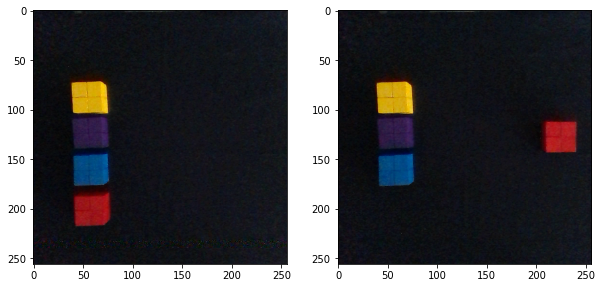

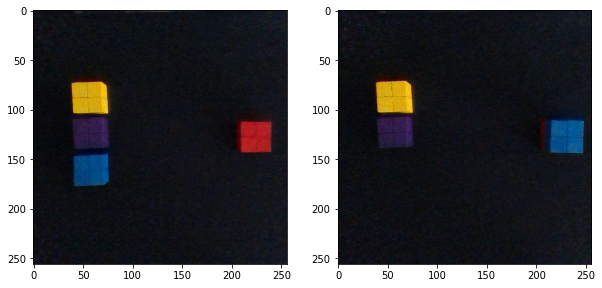

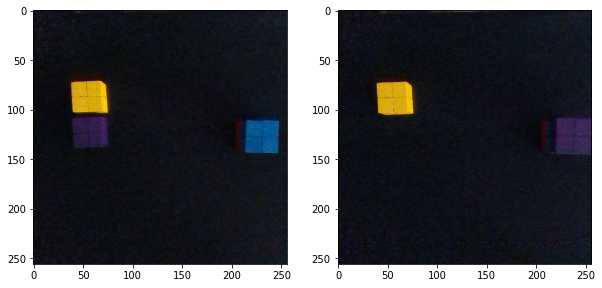

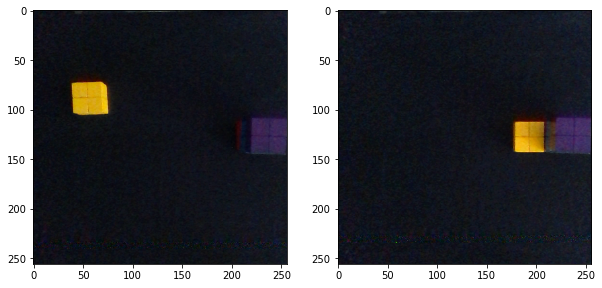

In [72]:
scene_idx = 38

curr_list = np.sort([meta_list[scene_idx]+'/'+x for x in os.listdir(meta_list[scene_idx])])
curr_rg_list = np.sort([rgbd_list[scene_idx]+'/'+x for x in os.listdir(rgbd_list[scene_idx])])
for i in range(len(curr_rg_list)-1):
    curr_data = joblib.load(curr_list[i])
    s_img = joblib.load(curr_rg_list[i])[:,:,0:3]
    s_img_depth = joblib.load(curr_rg_list[i])[:,:,3]

    e_img = joblib.load(curr_rg_list[i+1])[:,:,0:3]
    e_img_depth = joblib.load(curr_rg_list[i+1])[:,:,3]
    
    fig = plt.figure(figsize=(10,10))
    s_ax = fig.add_subplot(121)
    s_ax.imshow(s_img)
    e_ax = fig.add_subplot(122)
    e_ax.imshow(e_img) 
    
    plt.show()



# block segmentation

[76, 110, 199, 236]
[190, 222, 164, 195]
[115, 147, 147, 180]
[45, 81, 102, 133]
[166, 197, 71, 103]
[76, 110, 200, 236]
[114, 147, 149, 184]
[45, 80, 103, 133]
[166, 197, 71, 103]
[0.87166964 0.65972272 0.08948307]
[0.12805459 0.12541856 0.05320515]


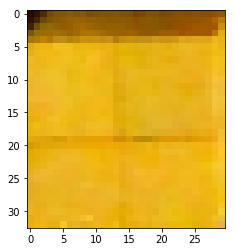

[0.77433862 0.13018985 0.16522461]
[0.02781668 0.02071284 0.02487538]


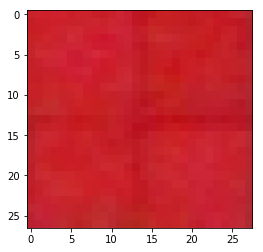

[0.01462861 0.34637786 0.60942239]
[0.02423752 0.03046864 0.03298214]


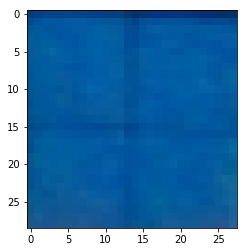

[0.11709786 0.35054466 0.23806736]
[0.02287895 0.02374153 0.02783888]


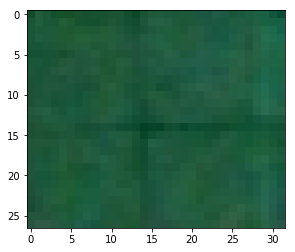

[0.23041291 0.14938272 0.35322129]
[0.01740607 0.01677874 0.02132445]


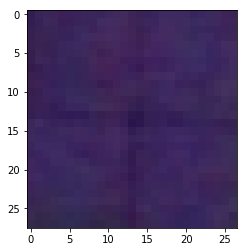

[76, 110, 200, 236]
[114, 147, 149, 184]
[45, 80, 103, 133]
[166, 197, 71, 103]
[109, 147, 149, 188]
[45, 80, 103, 133]
[166, 197, 71, 103]
[0.86739379 0.6551634  0.09319036]
[0.10882787 0.11442789 0.05454942]


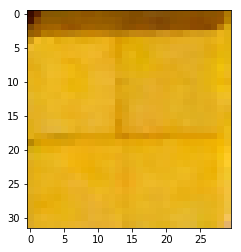

[0.75224323 0.09957905 0.12891012]
[0.03637407 0.02181767 0.0217941 ]


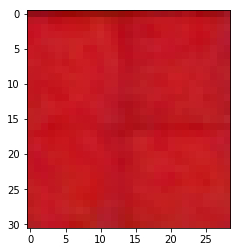

[0.10985258 0.30497738 0.20326473]
[0.02214667 0.01989431 0.02336764]


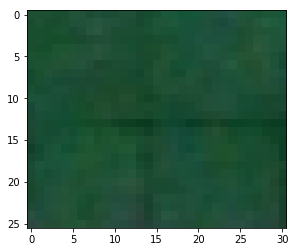

[0.22834838 0.14477643 0.35336134]
[0.01960546 0.01703466 0.0240841 ]


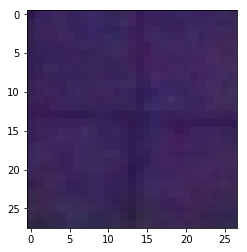

[109, 147, 149, 188]
[45, 80, 103, 133]
[166, 197, 71, 103]
[85, 147, 149, 188]
[166, 197, 71, 102]
[0.8960323  0.69483935 0.09836217]
[0.05871483 0.06567637 0.04737467]


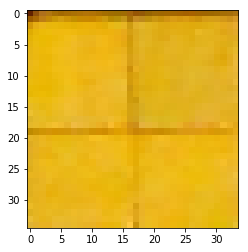

[0.09890527 0.28190045 0.1926872 ]
[0.02322361 0.02022588 0.02055154]


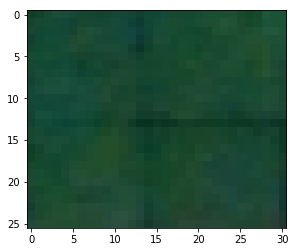

[0.21802054 0.14023758 0.33140886]
[0.01947572 0.01700882 0.02185529]


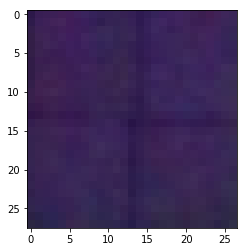

In [33]:
resume = 17
for scene_idx in range(resume, resume+1):
    curr_list = np.sort([meta_list[scene_idx]+'/'+x for x in os.listdir(meta_list[scene_idx])])
    curr_rg_list = np.sort([rgbd_list[scene_idx]+'/'+x for x in os.listdir(rgbd_list[scene_idx])])
    for i in range(len(curr_list)-1):
        curr_data = joblib.load(curr_list[i])
        s_img = joblib.load(curr_rg_list[i])[:,:,0:3]
        s_img_depth = joblib.load(curr_rg_list[i])[:,:,3]

        e_img = joblib.load(curr_rg_list[i+1])[:,:,0:3]
        e_img_depth = joblib.load(curr_rg_list[i+1])[:,:,3]
#         s_img = curr_data['start_image'][:,:,0:3]
#         s_img_depth = curr_data['end_image'][:,:,3]
#         e_img = curr_data['end_image'][:,:,0:3]
#         e_img_depth = curr_data['end_image'][:,:,3]
        
        
        
        s_hulls,s_objs = extract_objects(s_img)
        e_hulls,e_objs = extract_objects(e_img)


        for obj in s_objs :
            obj_img = s_img[obj[2]+2:obj[3]-2,obj[0]+2:obj[1]-2]
            print(np.mean(obj_img,axis=(0,1)))
            print(np.std(obj_img,axis=(0,1)))
            plt.imshow(obj_img)
            plt.show()
#         data_dict = dict()
#         pair_idx = []
#         no_care_idx = []

#         paired_e_idx = []
#         for s_idx, s_ob in enumerate(s_objs) :
#             s_counter = np.array([np.mean(s_ob[0:2]),np.mean(s_ob[2:4])])
#             for tr in range(4):
#                 e_idx = where_is(s_counter,e_objs)
#                 if e_idx != -1 :
#                     sd = int(min(s_ob[1] - s_ob[0],s_ob[3] - s_ob[2])/4.0)
#                     a = [sd,sd]
#                     iz = int(tr/2.0)
#                     a[iz] = np.power(-1, tr) * sd 
#                     e_idx = where_is(s_counter-a,e_objs)

#             if e_idx != -1 :
#                 e_ob = e_objs[e_idx]
#                 pair_idx.append([s_idx,e_idx])
#                 paired_e_idx.append(e_idx)

#                 randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
#             else :
#                 no_care_idx.append([0,s_idx])

#         for k in range(len(e_objs)):
#             if k in paired_e_idx : continue
#             else : 
#                 e_ob = e_objs[k]
#                 no_care_idx.append([1,k])

#         if len(pair_idx) == 0 :
#             print('-'*50 + 'check scene {0}, pic {1}'.format(scene_idx, i))

#         data_dict['start_image'] = np.concatenate([s_img,s_img_depth.reshape(256,256,1)],axis=2)
#         data_dict['end_image'] = np.concatenate([e_img,e_img_depth.reshape(256,256,1)],axis=2)
#         data_dict['pair_idx'] = pair_idx
#         data_dict['no_care_idx'] = no_care_idx
#         data_dict['start_objects'] = s_objs
#         data_dict['end_objects'] = e_objs
#         data_dict['start_pos'] = curr_data['start_pos']
#         data_dict['end_pos'] = curr_data['end_pos']

#         if not os.path.exists('/home/pre_generated/%04d'%scene_idx):
#             os.mkdir('/home/pre_generated/%04d'%scene_idx)

#         data_name = os.path.join('/home/obin/pre_generated/%04d'%scene_idx, '%04d.dat.gz'%i)
#         joblib.dump(data_dict,data_name)
        #print(data_name)


    break



In [62]:
color_book = {}
color = {}
color['mean'] = np.array([0.87166964,0.65972272, 0.08948307])
color['std'] = np.array([.12805459, 0.12541856, 0.05320515])
color_book['yellow'] = copy.deepcopy(color)

color['mean'] = np.array([0.77433862, 0.13018985, 0.16522461])
color['std'] = np.array([0.02781668, 0.02071284, 0.02487538])
color_book['red'] = copy.deepcopy(color)

color['mean'] = np.array([0.01462861, 0.34637786, 0.60942239])
color['std'] = np.array([0.02423752, 0.03046864, 0.03298214])
color_book['blue'] = copy.deepcopy(color)

color['mean'] = np.array([0.11709786, 0.35054466, 0.23806736])
color['std'] = np.array([0.02287895, 0.02374153, 0.02783888])
color_book['green'] = copy.deepcopy(color)

color['mean'] = np.array([0.23041291, 0.14938272, 0.35322129])
color['std'] = np.array([0.01740607, 0.01677874, 0.02132445])
color_book['purple'] = copy.deepcopy(color)


blue_mean = [0.01462861, 0.34637786, 0.60942239]
blue_std =[0.02423752, 0.03046864, 0.03298214]
green = [0.11709786, 0.35054466, 0.23806736]
green_std = [0.02287895, 0.02374153, 0.02783888]
purple = [0.23041291, 0.14938272, 0.35322129]
purple_std = [0.01740607, 0.01677874, 0.02132445]

In [67]:
for name, color in color_book.items():
    print(name, np.array(color['mean']*255,dtype=np.int64))

blue [  3  88 155]
yellow [222 168  22]
purple [58 38 90]
red [197  33  42]
green [29 89 60]


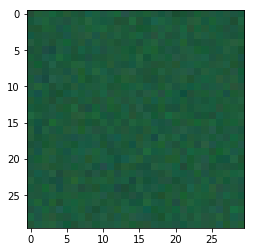

In [51]:
plt.imshow(np.random.normal(green,np.array(green_std)*0.8,size=(30,30,3)))
plt.show()

In [ ]:
y

In [ ]:
plt.imshow(s_img)
plt.show()

In [12]:
data_path = '/home/obin/t2b_dataset/pre_generated'
spd_list = np.sort([data_path+'/'+x for x in os.listdir(os.path.join(data_path,''))])
num_data = len(spd_list)
spd_list

array(['/home/obin/t2b_dataset/pre_generated/0000',
       '/home/obin/t2b_dataset/pre_generated/0001',
       '/home/obin/t2b_dataset/pre_generated/0002',
       '/home/obin/t2b_dataset/pre_generated/0003',
       '/home/obin/t2b_dataset/pre_generated/0004',
       '/home/obin/t2b_dataset/pre_generated/0005',
       '/home/obin/t2b_dataset/pre_generated/0006',
       '/home/obin/t2b_dataset/pre_generated/0007',
       '/home/obin/t2b_dataset/pre_generated/0008',
       '/home/obin/t2b_dataset/pre_generated/0009',
       '/home/obin/t2b_dataset/pre_generated/0010',
       '/home/obin/t2b_dataset/pre_generated/0011',
       '/home/obin/t2b_dataset/pre_generated/0012',
       '/home/obin/t2b_dataset/pre_generated/0013',
       '/home/obin/t2b_dataset/pre_generated/0014',
       '/home/obin/t2b_dataset/pre_generated/0015',
       '/home/obin/t2b_dataset/pre_generated/0016',
       '/home/obin/t2b_dataset/pre_generated/0017',
       '/home/obin/t2b_dataset/pre_generated/0018',
       '/hom

# check

In [14]:
fix_list = []

******************SCENE 169******************
-------------step 0-------------


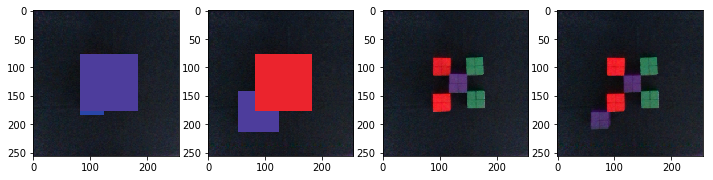

-------------step 1-------------


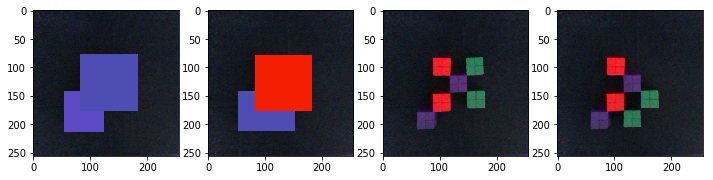

-------------step 2-------------


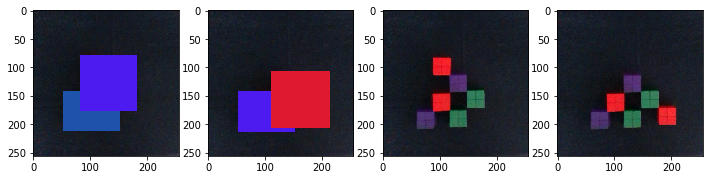

-------------step 3-------------


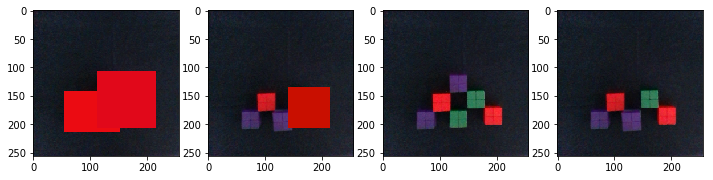

-------------step 4-------------


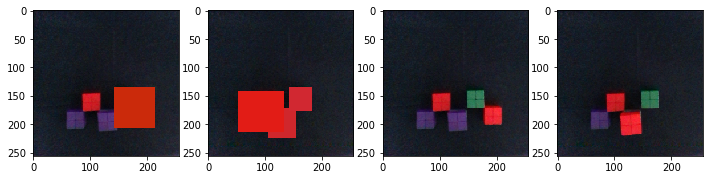

-------------step 5-------------


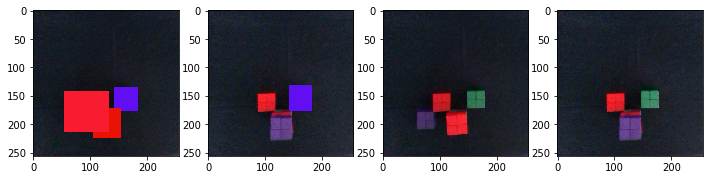

is it okay?no
which step do you want to fix?1
which step do you want to fix?2
which step do you want to fix?3
which step do you want to fix?4
which step do you want to fix?5
which step do you want to fix?q
-------------scene 1-------------


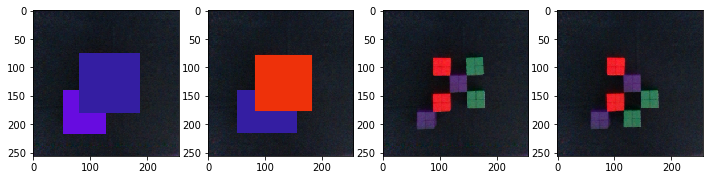

-------------scene 2-------------


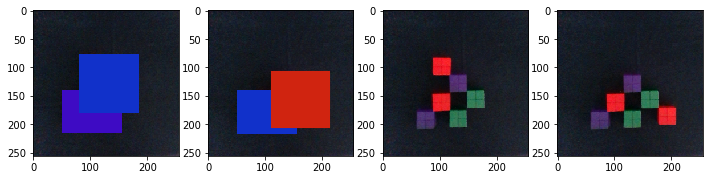

-------------scene 3-------------


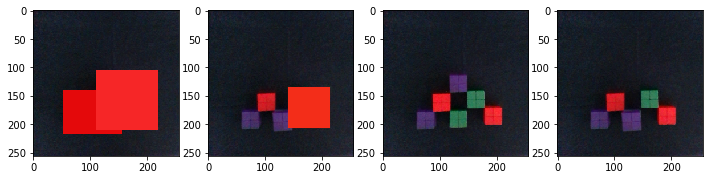

-------------scene 4-------------


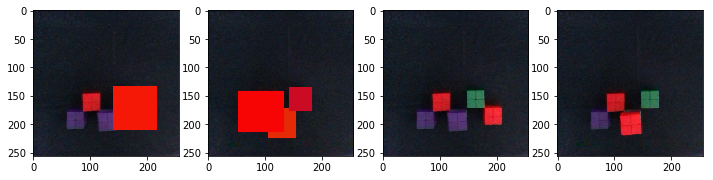

-------------scene 5-------------


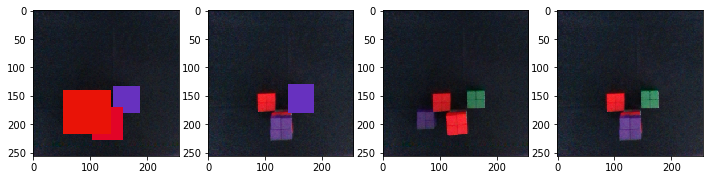

anything else?0
which step do you want to fix?0
which step do you want to fix?q
-------------scene 0-------------


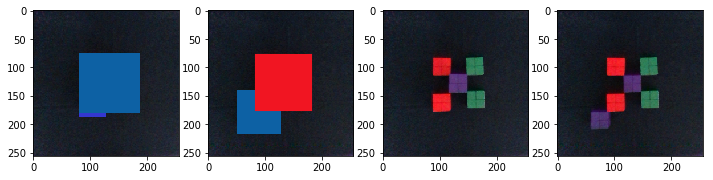

anything else?q
******************SCENE 170******************
-------------step 0-------------


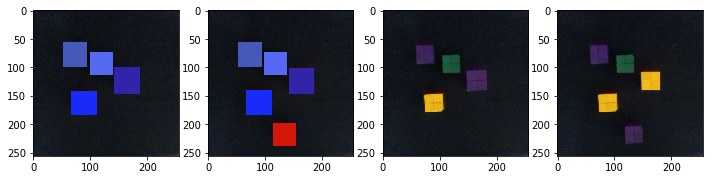

-------------step 1-------------


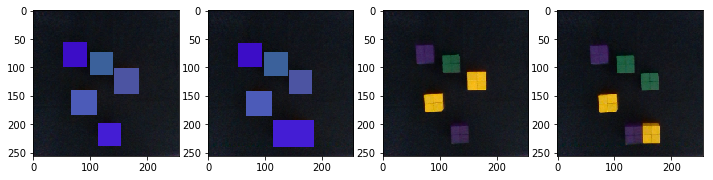

-------------step 2-------------


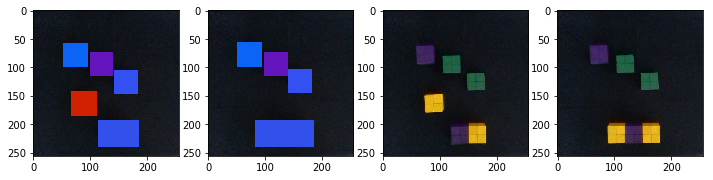

-------------step 3-------------


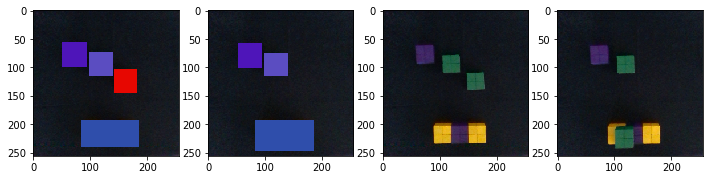

-------------step 4-------------


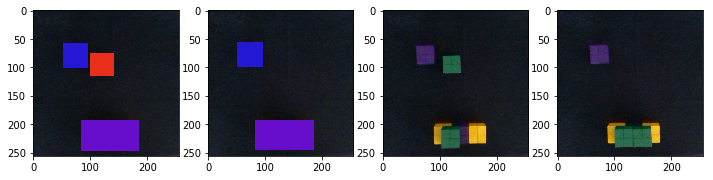

-------------step 5-------------


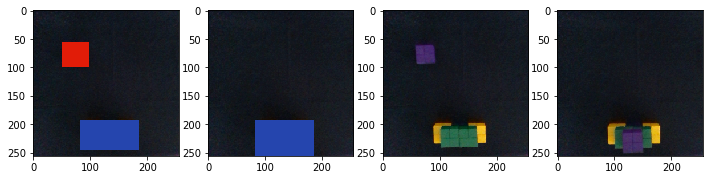

is it okay?yes






In [23]:
resume = 169
for scene_idx in range(resume, len(spd_list)):
    curr_list = np.sort([spd_list[scene_idx]+'/'+x for x in os.listdir(spd_list[scene_idx])])
    num_data = len(curr_list)
    print('******************SCENE %d******************'%scene_idx)
    for i in range(num_data):
        curr_data = joblib.load(curr_list[i])
        print('-------------step {0}-------------'.format(i))
        s_img = copy.deepcopy(curr_data['start_image'])
        e_img = copy.deepcopy(curr_data['end_image'])
        pair_idx = curr_data['pair_idx']
        no_care_idx = curr_data['no_care_idx']
        s_objs = curr_data['start_objects']
        e_objs = curr_data['end_objects']

        fig = plt.figure(figsize=(12,12))
        s_ax = fig.add_subplot(141)

        s_ax.imshow(s_img[:,:,0:3])
        e_ax = fig.add_subplot(142)
        e_ax.imshow(e_img[:,:,0:3])    
        s_ax2 = fig.add_subplot(143)
        s_ax2.imshow(s_img[:,:,0:3])
        e_ax2 = fig.add_subplot(144)
        e_ax2.imshow(e_img[:,:,0:3])

        for pair in pair_idx:
            s_ob = s_objs[pair[0]]
            e_ob = e_objs[pair[1]]

            randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
            rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                     linewidth=0.00,edgecolor=randcolor,facecolor=randcolor)
            s_ax.add_patch(rect)

            rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                     linewidth=0.0,edgecolor=randcolor,facecolor=randcolor)
            e_ax.add_patch(rect)

        for idx in no_care_idx :
            if idx[0] == 0 :
                s_ob = s_objs[idx[1]]
                randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                         linewidth=0.0,edgecolor=randcolor,facecolor=randcolor)
                s_ax.add_patch(rect)

            elif idx[0] == 1 :
                e_ob = e_objs[idx[1]]
                randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                         linewidth=0.00,edgecolor=randcolor,facecolor=randcolor)
                e_ax.add_patch(rect)

        plt.show()

    
    k = input('is it okay?')
    if k == 'yes' : 
        print('\n\n\n')
        continue
    elif k == 'stop' : break
    else : 
        while(True):
            fixes =[]
            while(True):
                fix = input('which step do you want to fix?')
                if fix == 'q' : break
                else : fixes.append(int(fix))
                    
            for fix in fixes : 
                curr_data = joblib.load(curr_list[fix])
                print('-------------scene {0}-------------'.format(fix))
                s_img = copy.deepcopy(curr_data['start_image'])
                e_img = copy.deepcopy(curr_data['end_image'])
                pair_idx = curr_data['pair_idx']
                no_care_idx = curr_data['no_care_idx']
                s_objs = curr_data['start_objects']
                e_objs = curr_data['end_objects']

                fig = plt.figure(figsize=(12,12))
                s_ax = fig.add_subplot(141)

                s_ax.imshow(s_img[:,:,0:3])
                e_ax = fig.add_subplot(142)
                e_ax.imshow(e_img[:,:,0:3])    
                s_ax2 = fig.add_subplot(143)
                s_ax2.imshow(s_img[:,:,0:3])
                e_ax2 = fig.add_subplot(144)
                e_ax2.imshow(e_img[:,:,0:3])

                for pair in pair_idx:
                    s_ob = s_objs[pair[0]]
                    e_ob = e_objs[pair[1]]

                    randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
                    rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                             linewidth=3,edgecolor=randcolor,facecolor=randcolor)
                    s_ax.add_patch(rect)

                    rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                             linewidth=3,edgecolor=randcolor,facecolor=randcolor)
                    e_ax.add_patch(rect)

                for idx in no_care_idx :
                    if idx[0] == 0 :
                        s_ob = s_objs[idx[1]]
                        randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                        rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                                 linewidth=3,edgecolor=randcolor,facecolor=randcolor)
                        s_ax.add_patch(rect)

                    elif idx[0] == 1 :
                        e_ob = e_objs[idx[1]]
                        randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
                        rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                                 linewidth=0.1,edgecolor=randcolor,facecolor=randcolor)
                        e_ax.add_patch(rect)
                        
                plt.show()


            message = input('anything else?')
            for fix in fixes :
                fix_list.append([scene_idx, fix, message])
            if message == 'q': break
            elif message == 'a': continue






# random generation

In [50]:
resume = 43
howmanytry = 100
max_gen = 10

for scene_idx in range(resume,resume+1):

    curr_list = np.sort([spd_list[scene_idx]+'/'+x for x in os.listdir(spd_list[scene_idx])])
    num_command = len(curr_list)
    save_path = spd_list[scene_idx].replace('pre_generated','generated')
    if not os.path.exists(save_path): os.mkdir(save_path)
    gen_num = 0
    for j in range(howmanytry):
        currently_ok = True
        s_imgs = []
        e_imgs = []

        for i in range(num_command):
            curr_data = joblib.load(curr_list[i])
            print('-------------scene {0}, step {1} ,{2}th generation-------------'.format(scene_idx,i,j))
            s_img = np.uint8(copy.deepcopy(curr_data['start_image'])*255)
            e_img = np.uint8(copy.deepcopy(curr_data['end_image'])*255)
            pair_idx = curr_data['pair_idx']
            no_care_idx = curr_data['no_care_idx']
            s_objs = curr_data['start_objects']
            e_objs = curr_data['end_objects']
            start_pos = curr_data['start_pos']
            end_pos = curr_data['end_pos']
            s_moves = []
            e_moves = []
            moving_object_idx = where_is(start_pos, s_objs)
            moved_object_idx = where_is(end_pos, e_objs)
            print('moving object s-{0} e-{1}'.format(moving_object_idx, moved_object_idx))
            
            for pair in pair_idx :
                for tr in range(6):
                    #print(i)
                    if i == 0 :
                        move = np.ones(4)
                        move[0:2] *= np.random.randint(-max_move1,max_move1+1)
                        move[2:4] *= np.random.randint(-max_move1,max_move1+1)
                    else :
                        #print(i)
                        for s, prev in enumerate(prev_moves):
                            if prev[0] == pair[0] : 
                                move = prev[1]
                                #print('found it!')
                                break
                            move = []
                        else:
                            currently_ok = False
                    if len(move) == 0: 
                        print('Not found')
                        currently_ok = False
                        break
                            
                    s, s_moved_img, s_moved_objs = move_object(pair[0],move,s_objs,s_img,black_patch)
                    e, e_moved_img, e_moved_objs = move_object(pair[1],move,e_objs,e_img,black_patch)
                    if s and e : 
                        s_img = s_moved_img
                        e_img = e_moved_img
                        s_objs = s_moved_objs
                        e_objs = e_moved_objs
                        s_moves.append([pair[0],move])
                        e_moves.append([pair[1],move])
                        print('suc ',move)
                        break
                    elif not (s and e) and i != 0 :
                        print('fail')
                        currently_ok = False
                        

            for idx in no_care_idx :
                for tr in range(6):
                    if i == 0 :
                        move = np.ones(4)
                        move[0:2] *= np.random.randint(-max_move1,max_move1+1)
                        move[2:4] *= np.random.randint(-max_move1,max_move1+1)
                    else :
                        for s, prev in enumerate(prev_moves):
                            if prev[0] == idx[1] : 
                                #print('foiund no care')
                                move = prev[1]
                                break
                            move = []
                            currently_ok = False
                    if len(move) == 0: break
                        
                    if idx[0] == 0 : 
                        result, s_moved_img, s_moved_objs = move_object(idx[1],move,s_objs,s_img,black_patch)
                        if result :
                            s_img = s_moved_img
                            s_objs = s_moved_objs
                            s_moves.append([idx[1],move])
                            break
                        else :
                            print('fail')
                            currently_ok = False
                    elif idx[0] == 1:
                        result, e_moved_img, e_moved_objs = move_object(idx[1],move,e_objs,e_img,black_patch)
                        if result:
                            e_img = e_moved_img
                            e_objs = e_moved_objs
                            e_moves.append([idx[1],move])
                            break
                        else :
                            print('fail')

                            currently_ok = False
                            

            prev_moves = copy.deepcopy(e_moves)
            start_pos = np.array(start_pos,dtype=np.int64)
            end_pos = np.array(end_pos,dtype=np.int64)
            
            s_img[start_pos[1]-2:start_pos[1]+2,start_pos[0]-2:start_pos[0]+2,0:3] = [255,255,255]
            s_img[end_pos[1]-2:end_pos[1]+2,end_pos[0]-2:end_pos[0]+2,0:3] = [255,255,255]
            
            for s, prev in enumerate(s_moves):
                if prev[0] == moving_object_idx : 
                    moving_object_move = prev[1]
                    print('start_post moved {0}, {1}'.format(moving_object_move[0],moving_object_move[2]))
                    start_pos = np.array(start_pos - [moving_object_move[0],moving_object_move[2]],dtype=np.int64)
                    break
            
            for s, prev in enumerate(e_moves):
                if prev[0] == moved_object_idx : 
                    moved_object_move = prev[1]
                    print('end_post moved {0}, {1}'.format(moved_object_move[0],moved_object_move[2]))
                    end_pos = np.array(end_pos - [moved_object_move[0],moved_object_move[2]],dtype=np.int64)
                    break
            

            s_img[start_pos[1]-2:start_pos[1]+2,start_pos[0]-2:start_pos[0]+2,0:3] = [255,0,255]
            s_img[end_pos[1]-2:end_pos[1]+2,end_pos[0]-2:end_pos[0]+2,0:3] = [51,204,255]
            
            if currently_ok : 
                s_imgs.append(s_img)
                e_imgs.append(e_img)
            else :
                print('FAILED')
                break

            
        if currently_ok : 
            print('gen_num %d'%gen_num)
            for i in range(num_command) :
                plt.imsave(os.path.join(save_path,'%04d.png'%(gen_num*100+i)),s_imgs[i][:,:,0:3])
                if i == num_command - 1 :
                    plt.imsave(os.path.join(save_path,'%04d.png'%(gen_num*100+i+1)),e_imgs[i][:,:,0:3])
            gen_num += 1
            

        if gen_num == max_gen :
            break
            
        print('\n\n\n')
#             kernel = np.ones((3,3),np.float32)/(3*2)
#             s_img = cv2.filter2D(s_img,-1,kernel)
#             for tx in range(256):
#                 for ty in range(256):
#                     color = np.array(s_img[tx,ty,:],dtype=np.int64)
#                     if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
#                         s_img[tx,ty,:] = [30,30,30]

#             e_img = cv2.filter2D(e_img,-1,kernel)
#             for tx in range(256):
#                 for ty in range(256):
#                     color = np.array(e_img[tx,ty,:],dtype=np.int64)
#                     if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
#                         e_img[tx,ty,:] = [30,30,30]

#             stacked_img = np.hstack([s_img,e_img])
#             plt.imsave(os.path.join(save_path,'img/%02th/%04.png'%(j,i),stacked_img)
    







    

-------------scene 43, step 0 ,0th generation-------------
moving object s-0 e-1
suc  [-10. -10.  -9.  -9.]
start_post moved -10.0, -9.0
end_post moved -6.0, -6.0
-------------scene 43, step 1 ,0th generation-------------
moving object s-0 e-2
suc  [-6. -6. -6. -6.]
start_post moved -10.0, -9.0
end_post moved -6.0, -6.0
FAILED




-------------scene 43, step 0 ,1th generation-------------
moving object s-0 e-1
suc  [  4.   4. -18. -18.]
start_post moved 4.0, -18.0
end_post moved -1.0, -5.0
-------------scene 43, step 1 ,1th generation-------------
moving object s-0 e-2
suc  [-1. -1. -5. -5.]
start_post moved 4.0, -18.0
end_post moved -1.0, -5.0
FAILED




-------------scene 43, step 0 ,2th generation-------------
moving object s-0 e-1
suc  [ -5.  -5. -14. -14.]
start_post moved -5.0, -14.0
end_post moved -11.0, 0.0
-------------scene 43, step 1 ,2th generation-------------
moving object s-0 e-2
suc  [-11. -11.   0.   0.]
start_post moved -5.0, -14.0
end_post moved -11.0, 0.0
FAILED





-------------scene 43, step 0 ,27th generation-------------
moving object s-0 e-1
suc  [6. 6. 0. 0.]
start_post moved 6.0, 0.0
end_post moved 3.0, -17.0
-------------scene 43, step 1 ,27th generation-------------
moving object s-0 e-2
suc  [  3.   3. -17. -17.]
start_post moved 6.0, 0.0
end_post moved 3.0, -17.0
FAILED




-------------scene 43, step 0 ,28th generation-------------
moving object s-0 e-1
suc  [ 2.  2. 19. 19.]
start_post moved 2.0, 19.0
end_post moved -4.0, 7.0
-------------scene 43, step 1 ,28th generation-------------
moving object s-0 e-2
suc  [-4. -4.  7.  7.]
start_post moved 2.0, 19.0
end_post moved -4.0, 7.0
FAILED




-------------scene 43, step 0 ,29th generation-------------
moving object s-0 e-1
suc  [-17. -17.   6.   6.]
start_post moved -17.0, 6.0
end_post moved 8.0, -7.0
-------------scene 43, step 1 ,29th generation-------------
moving object s-0 e-2
suc  [ 8.  8. -7. -7.]
fail
fail
fail
fail
fail
fail
start_post moved -17.0, 6.0
end_post moved 8.0, -7.0


-------------scene 43, step 1 ,54th generation-------------
moving object s-0 e-2
suc  [-11. -11.   8.   8.]
start_post moved -12.0, 19.0
end_post moved -11.0, 8.0
FAILED




-------------scene 43, step 0 ,55th generation-------------
moving object s-0 e-1
suc  [-19. -19.  15.  15.]
start_post moved -19.0, 15.0
end_post moved -15.0, 4.0
-------------scene 43, step 1 ,55th generation-------------
moving object s-0 e-2
suc  [-15. -15.   4.   4.]
fail
fail
fail
fail
fail
fail
start_post moved -19.0, 15.0
end_post moved -15.0, 4.0
FAILED




-------------scene 43, step 0 ,56th generation-------------
moving object s-0 e-1
suc  [  8.   8. -14. -14.]
start_post moved 8.0, -14.0
end_post moved -9.0, 5.0
-------------scene 43, step 1 ,56th generation-------------
moving object s-0 e-2
suc  [-9. -9.  5.  5.]
start_post moved 8.0, -14.0
end_post moved -9.0, 5.0
FAILED




-------------scene 43, step 0 ,57th generation-------------
moving object s-0 e-1
suc  [-4. -4.  3.  3.]
start_post moved -4.

-------------scene 43, step 0 ,80th generation-------------
moving object s-0 e-1
suc  [ 8.  8. 18. 18.]
start_post moved 8.0, 18.0
end_post moved -15.0, -18.0
-------------scene 43, step 1 ,80th generation-------------
moving object s-0 e-2
suc  [-15. -15. -18. -18.]
start_post moved 8.0, 18.0
end_post moved -15.0, -18.0
FAILED




-------------scene 43, step 0 ,81th generation-------------
moving object s-0 e-1
suc  [-20. -20.   3.   3.]
start_post moved -20.0, 3.0
end_post moved 1.0, -2.0
-------------scene 43, step 1 ,81th generation-------------
moving object s-0 e-2
suc  [ 1.  1. -2. -2.]
fail
fail
fail
fail
fail
fail
start_post moved -20.0, 3.0
end_post moved 1.0, -2.0
FAILED




-------------scene 43, step 0 ,82th generation-------------
moving object s-0 e-1
suc  [ -5.  -5. -15. -15.]
start_post moved -5.0, -15.0
end_post moved -9.0, -1.0
-------------scene 43, step 1 ,82th generation-------------
moving object s-0 e-2
suc  [-9. -9. -1. -1.]
start_post moved -5.0, -15.0
end_po

# CHECK GENRATED

In [5]:
data_path = '/home/obin/t2b_dataset/generated'
generated_list = np.sort([data_path+'/'+x for x in os.listdir(os.path.join(data_path,''))])
num_data = len(generated_list)
watch_list = []


In [ ]:
resume = 39
for scene_idx in range(resume, num_data):
    curr_list = np.sort([generated_list[scene_idx]+'/'+x for x in os.listdir(generated_list[scene_idx])])
    num_command = len(curr_list)
    if num_command == 0 :
        watch_list.append(scene_idx)
        continue
    winname = '%04d'%(scene_idx)
    cv2.namedWindow(winname)
    cv2.moveWindow(winname,350,500)
    for i in range(len(curr_list)) :
        img = cv2.imread(curr_list[i])
        cv2.imshow(winname,img)           
        key = cv2.waitKey()
        if key & 0xFF == ord('s'):
            watch_list.append(scene_idx)
        elif key & 0xFF == ord('q'):
            break
    if key & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

    